# Multi-Decade Urban Growth: 30+ Years of Change

In this notebook, we'll track urban expansion over **multiple decades** using Landsat satellite data.

**Why Landsat?**
- Sentinel-2 only started in 2015
- Landsat has continuous data from **1984 to present**
- Lower resolution (30m vs 10m) but much longer time series

**What we'll see:**
- 1990s → 2010 → 2020 → 2024
- ~30 years of urban transformation
- A city growing from the past to the present

---
## 1. Setup

In [1]:
from pystac_client import Client
import planetary_computer as pc
from odc.stac import stac_load

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
print("Connected to Planetary Computer")

Connected to Planetary Computer


---
## 2. Understanding Landsat Missions

| Mission | Years | Sensor | Resolution |
|---------|-------|--------|------------|
| Landsat 5 | 1984-2013 | TM | 30m |
| Landsat 7 | 1999-present | ETM+ | 30m |
| Landsat 8 | 2013-present | OLI | 30m |
| Landsat 9 | 2021-present | OLI-2 | 30m |

**Band differences:**
- Landsat 5/7: NIR=B4, SWIR1=B5
- Landsat 8/9: NIR=B5, SWIR1=B6

We'll handle these differences in our code.

---
## 3. Select Location and Time Periods

We'll analyze **Denver, Colorado** across 4 time periods spanning ~30 years.

Denver is one of the fastest-growing metro areas in the United States, with massive suburban expansion into the surrounding plains and foothills.

In [2]:
# Denver, Colorado - Metro area expansion
# Converting from lat,lon points to bbox [min_lon, min_lat, max_lon, max_lat]
city_name = "Denver, Colorado, USA"
bbox = [-105.186, 39.560, -104.648, 39.944]

# Four time periods spanning ~30 years
# Using spring/fall to avoid winter snow and summer haze
time_periods = {
    "1995": "1994-09-01/1996-05-31",  # Mid-90s (Landsat 5)
    "2005": "2004-09-01/2006-05-31",  # Mid-2000s (Landsat 5/7)
    "2015": "2014-09-01/2016-05-31",  # Mid-2010s (Landsat 8)
    "2024": "2023-09-01/2024-11-30",  # Current (Landsat 8/9)
}

print(f"City: {city_name}")
print(f"\\nTime periods to analyze:")
for label, dates in time_periods.items():
    print(f"  {label}: {dates}")

City: Denver, Colorado, USA
\nTime periods to analyze:
  1995: 1994-09-01/1996-05-31
  2005: 2004-09-01/2006-05-31
  2015: 2014-09-01/2016-05-31
  2024: 2023-09-01/2024-11-30


---
## 4. Helper Functions for Landsat

In [3]:
def normalize_for_display(img, pmin=2, pmax=98):
    """Normalize image to 0-1 range for display."""
    lo, hi = np.nanpercentile(img, [pmin, pmax])
    return np.clip((img - lo) / (hi - lo + 1e-6), 0, 1)

def compute_ndbi(swir, nir):
    """Compute Normalized Difference Built-up Index: (SWIR - NIR) / (SWIR + NIR)"""
    swir = swir.astype('float32')
    nir = nir.astype('float32')
    return (swir - nir) / (swir + nir + 1e-6)

def compute_ndvi(nir, red):
    """Compute Normalized Difference Vegetation Index: (NIR - Red) / (NIR + Red)"""
    nir = nir.astype('float32')
    red = red.astype('float32')
    return (nir - red) / (nir + red + 1e-6)

def load_landsat_image(catalog, bbox, date_range, max_cloud=20):
    """
    Load a Landsat image, automatically handling different missions.
    Returns data with standardized band names.
    """
    # Search Landsat Collection 2 Level-2
    search = catalog.search(
        collections=["landsat-c2-l2"],
        bbox=bbox,
        datetime=date_range,
        query={"eo:cloud_cover": {"lt": max_cloud}},
    )
    items = list(search.items())
    
    if len(items) == 0:
        print(f"  No images with <{max_cloud}% clouds. Trying with <40% clouds...")
        search = catalog.search(
            collections=["landsat-c2-l2"],
            bbox=bbox,
            datetime=date_range,
            query={"eo:cloud_cover": {"lt": 40}},
        )
        items = list(search.items())
    
    if len(items) == 0:
        raise ValueError(f"No images found for {date_range}")
    
    # Get clearest image
    items_sorted = sorted(items, key=lambda x: x.properties.get('eo:cloud_cover', 100))
    item = items_sorted[0]
    
    # Determine which Landsat mission
    platform = item.properties.get('platform', '')
    
    # Define bands based on mission
    # Landsat 5/7: red=B3, green=B2, blue=B1, nir=B4, swir=B5
    # Landsat 8/9: red=B4, green=B3, blue=B2, nir=B5, swir=B6
    if 'landsat-5' in platform.lower() or 'landsat-7' in platform.lower():
        bands = ["blue", "green", "red", "nir08", "swir16"]
        mission = "Landsat 5/7"
    else:  # Landsat 8 or 9
        bands = ["blue", "green", "red", "nir08", "swir16"]
        mission = "Landsat 8/9"
    
    signed_item = pc.sign(item)
    
    data = stac_load(
        [signed_item],
        bands=bands,
        bbox=bbox,
        crs="EPSG:4326",
        resolution=0.0003,  # ~30m at equator
        groupby="solar_day",
    )
    
    return data, item, mission

print("Helper functions defined.")

Helper functions defined.


---
## 5. Load Images from All Four Decades

In [4]:
# Store results
images = {}

for label, date_range in time_periods.items():
    print(f"\nLoading {label}...")
    try:
        data, item, mission = load_landsat_image(catalog, bbox, date_range)
        images[label] = {
            'data': data,
            'item': item,
            'mission': mission,
            'date': item.datetime.strftime('%Y-%m-%d'),
            'cloud': item.properties.get('eo:cloud_cover', 0)
        }
        print(f"  Date: {images[label]['date']}")
        print(f"  Mission: {mission}")
        print(f"  Cloud cover: {images[label]['cloud']:.1f}%")
    except Exception as e:
        print(f"  ERROR: {e}")
        images[label] = None

# Check which periods we got
available_periods = [k for k, v in images.items() if v is not None]
print(f"\nSuccessfully loaded: {available_periods}")


Loading 1995...
  Date: 1996-03-26
  Mission: Landsat 5/7
  Cloud cover: 0.0%

Loading 2005...
  Date: 2006-04-16
  Mission: Landsat 5/7
  Cloud cover: 0.0%

Loading 2015...
  Date: 2015-10-10
  Mission: Landsat 5/7
  Cloud cover: 0.0%

Loading 2024...
  Date: 2024-10-02
  Mission: Landsat 8/9
  Cloud cover: 0.0%

Successfully loaded: ['1995', '2005', '2015', '2024']


---
## 6. Process All Images

In [5]:
# Process each image - extract bands, compute indices
processed = {}

for label, img_data in images.items():
    if img_data is None:
        continue
    
    data = img_data['data']
    
    # Extract bands (using standardized names from Planetary Computer)
    red = data["red"].isel(time=0).values
    green = data["green"].isel(time=0).values
    blue = data["blue"].isel(time=0).values
    nir = data["nir08"].isel(time=0).values
    swir = data["swir16"].isel(time=0).values
    
    # Create RGB composite
    rgb = normalize_for_display(np.stack([red, green, blue], axis=-1))
    
    # Compute indices
    ndbi = compute_ndbi(swir, nir)
    ndvi = compute_ndvi(nir, red)
    
    # Calculate urban percentage
    urban_pct = 100 * np.sum(ndbi > 0.05) / ndbi.size
    
    processed[label] = {
        'rgb': rgb,
        'ndbi': ndbi,
        'ndvi': ndvi,
        'urban_pct': urban_pct,
        'date': img_data['date'],
        'mission': img_data['mission']
    }
    
    print(f"{label}: Urban coverage = {urban_pct:.1f}%")

# Get image shape from first available
first_key = list(processed.keys())[0]
img_height, img_width = processed[first_key]['rgb'].shape[:2]
aspect_ratio = img_width / img_height
print(f"\nImage dimensions: {img_height} x {img_width}, aspect ratio: {aspect_ratio:.2f}")

1995: Urban coverage = 5.7%
2005: Urban coverage = 40.4%
2015: Urban coverage = 22.9%
2024: Urban coverage = 17.1%

Image dimensions: 1281 x 1794, aspect ratio: 1.40


---
## 7. True Color Comparison Across Decades

In [6]:
# Plot all available periods
n_periods = len(processed)
subplot_width = 5
subplot_height = subplot_width / aspect_ratio

fig, axes = plt.subplots(1, n_periods, figsize=(subplot_width * n_periods, subplot_height))
if n_periods == 1:
    axes = [axes]

for idx, (label, data) in enumerate(processed.items()):
    axes[idx].imshow(data['rgb'], aspect='auto')
    axes[idx].set_title(f"{label}\n{data['date']}\n({data['mission']})", fontsize=12)
    axes[idx].axis('off')

plt.suptitle(f"True Color: {city_name} Through the Decades", fontsize=16)
plt.tight_layout()
plt.show()

---
## 8. NDBI Comparison Across Decades

In [7]:
fig, axes = plt.subplots(1, n_periods, figsize=(subplot_width * n_periods, subplot_height + 0.5))
if n_periods == 1:
    axes = [axes]

for idx, (label, data) in enumerate(processed.items()):
    im = axes[idx].imshow(data['ndbi'], cmap='RdYlGn_r', vmin=-0.3, vmax=0.3, aspect='auto')
    axes[idx].set_title(f"{label}\nUrban: {data['urban_pct']:.1f}%", fontsize=12)
    axes[idx].axis('off')

plt.suptitle("NDBI (Built-up Index) — Watch the City Grow!", fontsize=16)
plt.tight_layout()

# Add colorbar
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.03])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('NDBI (red/orange = urban, green = vegetation)', fontsize=10)
plt.subplots_adjust(bottom=0.15)
plt.show()

---
## 9. Urban Growth Timeline

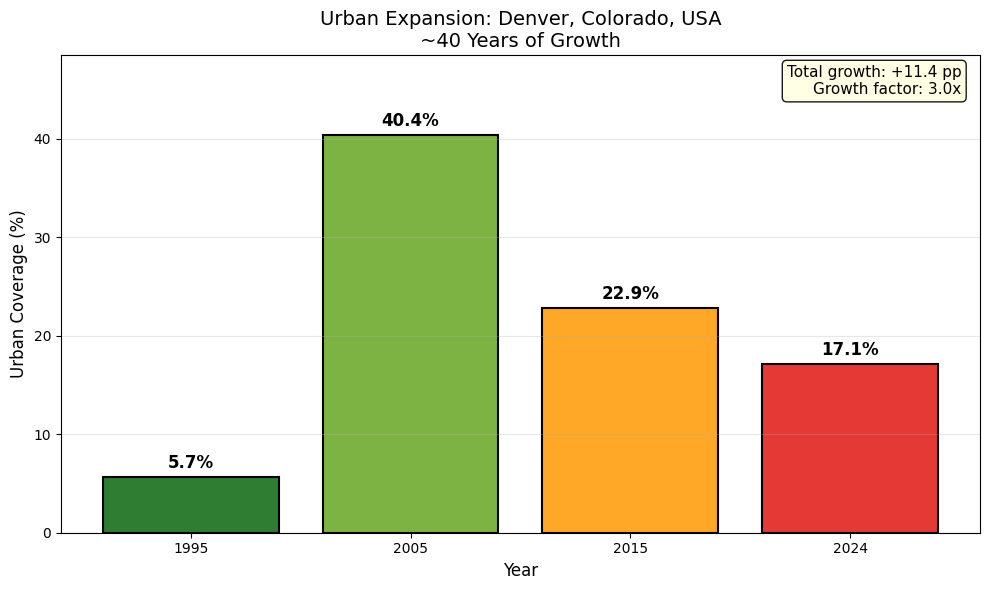

In [8]:
# Create urban growth chart
years = []
urban_pcts = []
labels = []

for label, data in processed.items():
    year = int(data['date'][:4])
    years.append(year)
    urban_pcts.append(data['urban_pct'])
    labels.append(label)

fig, ax = plt.subplots(figsize=(10, 6))

# Bar chart
bars = ax.bar(labels, urban_pcts, color=['#2E7D32', '#7CB342', '#FFA726', '#E53935'][:len(labels)], 
              edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, pct in zip(bars, urban_pcts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f'{pct:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Urban Coverage (%)', fontsize=12)
ax.set_xlabel('Year', fontsize=12)
ax.set_title(f'Urban Expansion: {city_name}\n~{len(years)*10} Years of Growth', fontsize=14)
ax.set_ylim(0, max(urban_pcts) * 1.2)
ax.grid(axis='y', alpha=0.3)

# Calculate growth
if len(urban_pcts) >= 2:
    total_growth = urban_pcts[-1] - urban_pcts[0]
    growth_factor = urban_pcts[-1] / urban_pcts[0] if urban_pcts[0] > 0 else 0
    ax.text(0.98, 0.98, f'Total growth: +{total_growth:.1f} pp\nGrowth factor: {growth_factor:.1f}x', 
            transform=ax.transAxes, ha='right', va='top', fontsize=11,
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))

plt.tight_layout()
plt.show()

---
## 10. Decade-by-Decade Change Detection

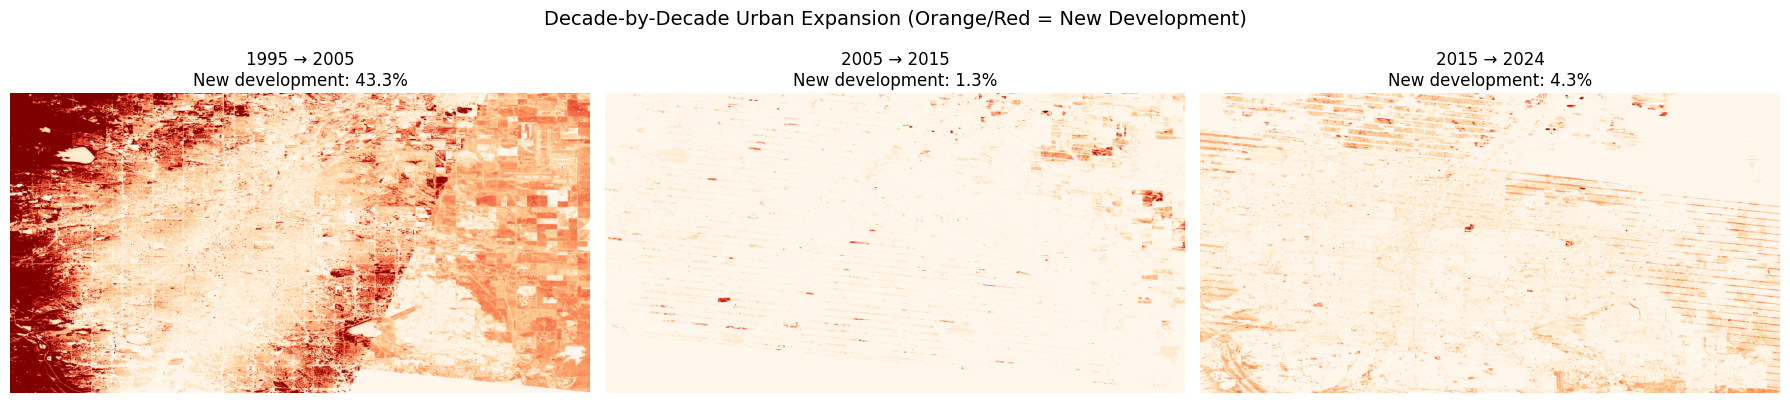

In [9]:
# Compare consecutive periods
period_keys = list(processed.keys())

if len(period_keys) >= 2:
    n_comparisons = len(period_keys) - 1
    fig, axes = plt.subplots(1, n_comparisons, figsize=(6 * n_comparisons, subplot_height + 0.5))
    if n_comparisons == 1:
        axes = [axes]
    
    for idx in range(n_comparisons):
        early_key = period_keys[idx]
        later_key = period_keys[idx + 1]
        
        # Compute change
        dndbi = processed[later_key]['ndbi'] - processed[early_key]['ndbi']
        
        # New development = positive dNDBI
        im = axes[idx].imshow(dndbi, cmap='OrRd', vmin=0, vmax=0.25, aspect='auto')
        
        new_dev_pct = 100 * np.sum(dndbi > 0.08) / dndbi.size
        axes[idx].set_title(f"{early_key} → {later_key}\nNew development: {new_dev_pct:.1f}%", fontsize=12)
        axes[idx].axis('off')
    
    plt.suptitle("Decade-by-Decade Urban Expansion (Orange/Red = New Development)", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("Need at least 2 time periods for change detection")

---
## 11. Total Change: First to Last

In [10]:
if len(period_keys) >= 2:
    first_key = period_keys[0]
    last_key = period_keys[-1]
    
    # Compute total change
    total_dndbi = processed[last_key]['ndbi'] - processed[first_key]['ndbi']
    
    # Classify change
    def classify_change(early_ndbi, recent_ndbi):
        change = np.zeros_like(early_ndbi, dtype=np.int8)
        urban_threshold = 0.05
        
        # Stable urban
        change[(early_ndbi > urban_threshold) & (recent_ndbi > urban_threshold)] = 0
        # New development
        change[(early_ndbi <= urban_threshold) & (recent_ndbi > urban_threshold)] = 1
        # Stable non-urban
        change[(early_ndbi <= urban_threshold) & (recent_ndbi <= urban_threshold)] = 2
        # Became greener (rare)
        change[(early_ndbi > urban_threshold) & (recent_ndbi <= urban_threshold)] = 3
        
        return change
    
    change_map = classify_change(processed[first_key]['ndbi'], processed[last_key]['ndbi'])
    
    # Create figure
    colors = ['#888888', '#FF4400', '#228B22', '#90EE90']
    cmap_change = ListedColormap(colors)
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
    norm = BoundaryNorm(bounds, cmap_change.N)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, subplot_height))
    
    # First period
    axes[0].imshow(processed[first_key]['rgb'], aspect='auto')
    axes[0].set_title(f"{first_key}\n{processed[first_key]['date']}", fontsize=12)
    axes[0].axis('off')
    
    # Last period
    axes[1].imshow(processed[last_key]['rgb'], aspect='auto')
    axes[1].set_title(f"{last_key}\n{processed[last_key]['date']}", fontsize=12)
    axes[1].axis('off')
    
    # Change map
    axes[2].imshow(change_map, cmap=cmap_change, norm=norm, aspect='auto')
    axes[2].set_title(f"Total Urban Expansion\n{first_key} → {last_key}", fontsize=12)
    axes[2].axis('off')
    
    # Legend
    patches = [
        mpatches.Patch(color=colors[0], label=f'Stable Urban ({100*np.sum(change_map==0)/change_map.size:.1f}%)'),
        mpatches.Patch(color=colors[1], label=f'NEW Development ({100*np.sum(change_map==1)/change_map.size:.1f}%)'),
        mpatches.Patch(color=colors[2], label=f'Stable Non-Urban ({100*np.sum(change_map==2)/change_map.size:.1f}%)'),
    ]
    axes[2].legend(handles=patches, loc='lower right', fontsize=9)
    
    years_span = int(processed[last_key]['date'][:4]) - int(processed[first_key]['date'][:4])
    plt.suptitle(f"{city_name}: {years_span} Years of Urban Transformation", fontsize=16)
    plt.tight_layout()
    plt.show()

---
## 12. Multi-Decade Growth Report

In [11]:
pixel_area_hectares = 0.09  # ~30m resolution = 0.09 hectares per pixel

print("="*70)
print("MULTI-DECADE URBAN GROWTH REPORT")
print("="*70)
print(f"City: {city_name}")
print(f"Analysis period: {period_keys[0]} to {period_keys[-1]}")
print("="*70)

print("\nUrban Coverage by Period:")
print("-"*70)

prev_urban = None
for label, data in processed.items():
    urban_area = np.sum(data['ndbi'] > 0.05) * pixel_area_hectares
    
    growth_str = ""
    if prev_urban is not None:
        growth = data['urban_pct'] - prev_urban
        growth_str = f" (+{growth:.1f}pp from previous)"
    
    print(f"\n{label} ({data['date']}, {data['mission']}):")
    print(f"  Urban coverage: {data['urban_pct']:.1f}%{growth_str}")
    print(f"  Estimated urban area: ~{urban_area:.0f} hectares")
    
    prev_urban = data['urban_pct']

# Summary statistics
if len(processed) >= 2:
    first_data = list(processed.values())[0]
    last_data = list(processed.values())[-1]
    
    total_growth_pp = last_data['urban_pct'] - first_data['urban_pct']
    growth_factor = last_data['urban_pct'] / first_data['urban_pct'] if first_data['urban_pct'] > 0 else 0
    
    first_year = int(first_data['date'][:4])
    last_year = int(last_data['date'][:4])
    years = last_year - first_year
    annual_growth = total_growth_pp / years if years > 0 else 0
    
    print("\n" + "="*70)
    print("SUMMARY")
    print("="*70)
    print(f"Time span: {years} years ({first_year} → {last_year})")
    print(f"Urban coverage change: {first_data['urban_pct']:.1f}% → {last_data['urban_pct']:.1f}%")
    print(f"Total growth: +{total_growth_pp:.1f} percentage points")
    print(f"Growth factor: {growth_factor:.2f}x")
    print(f"Average annual growth: +{annual_growth:.2f} pp/year")
    print("="*70)

MULTI-DECADE URBAN GROWTH REPORT
City: Denver, Colorado, USA
Analysis period: 1995 to 2024

Urban Coverage by Period:
----------------------------------------------------------------------

1995 (1996-03-26, Landsat 5/7):
  Urban coverage: 5.7%
  Estimated urban area: ~11767 hectares

2005 (2006-04-16, Landsat 5/7):
  Urban coverage: 40.4% (+34.7pp from previous)
  Estimated urban area: ~83569 hectares

2015 (2015-10-10, Landsat 5/7):
  Urban coverage: 22.9% (+-17.5pp from previous)
  Estimated urban area: ~47305 hectares

2024 (2024-10-02, Landsat 8/9):
  Urban coverage: 17.1% (+-5.8pp from previous)
  Estimated urban area: ~35366 hectares

SUMMARY
Time span: 28 years (1996 → 2024)
Urban coverage change: 5.7% → 17.1%
Total growth: +11.4 percentage points
Growth factor: 3.01x
Average annual growth: +0.41 pp/year


---
## Summary: Multi-Decade Analysis

### What makes this analysis powerful:

| Aspect | Benefit |
|--------|--------|
| **30+ years of data** | See long-term transformation, not just recent changes |
| **Multiple snapshots** | Understand when growth accelerated |
| **Consistent methodology** | NDBI works across all Landsat missions |
| **Quantified results** | Growth rates, total expansion in hectares |

### Key insight:

By combining Landsat missions spanning decades, we can watch a city transform from a smaller urban center to a sprawling metropolis — something impossible with newer satellites alone.

### Applications:

- **Urban planning:** Understand historical growth patterns to predict future expansion
- **Climate research:** Track urban heat island development over time
- **Environmental impact:** Measure cumulative habitat loss
- **Policy evaluation:** Did growth boundaries or zoning policies work?